In [1]:
%matplotlib inline
import matplotlib.pyplot as plt


import os
import itertools
import json
import numpy as np
import pandas as pd
import pickle
import requests
import seaborn as sns
import collections
from collections import Counter
import scipy
import time
import copy
from collections import OrderedDict

import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition.pca import PCA


import nltk
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
import gensim
import re
from fuzzywuzzy import process

from gensim.scripts.glove2word2vec import glove2word2vec

/Users/stefgarasto/miniconda3/envs/nlp/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [2]:
from utils_nos import nesta_colours, nesta_colours_combos

[[1, 0.7215686274509804, 0.09803921568627451], [1, 0, 0.2549019607843137], [0, 0, 0], [1, 0.35294117647058826, 0], [0.6078431372549019, 0, 0.7647058823529411], [0.6470588235294118, 0.5803921568627451, 0.5098039215686274], [0.6274509803921569, 0.5686274509803921, 0.1568627450980392], [0.7686274509803922, 0.6901960784313725, 0], [0.9647058823529412, 0.49411764705882355, 0], [0.7843137254901961, 0.1568627450980392, 0.5725490196078431], [0.23529411764705882, 0.07058823529411765, 0.3215686274509804]] [[0, 1, 2, 3, 4, 5], [0, 6, 7], [1, 3, 8], [4, 9, 10], [8, 5], [1, 11]]


In [3]:
# set up plot style
print(plt.style.available)
plt.style.use(['seaborn-darkgrid','seaborn-poster','ggplot'])

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


#### TODOs for data cleaning:

1. remove square brackets
2. make everything lower case


## Overview

This notebook contains a few functions and snippets of code that are useful for analysing text. Most of the techniques used are unsupervised. Functions are defined up front and then used in sections below.

This notebook is to apply:
- Tokenizers (based on n-grams and 'as_is')
- Calculating distance
- Hierarchical clustering and plotting
- K-means clustering
- LSH

This specific instance of the notebook will be applied to the analysis of NOS


In [4]:
# flatten lists of lists
def flatten_lol(t):
    return list(itertools.chain.from_iterable(t))
flatten_lol([[1,2],[3],[4,5,6]])


[1, 2, 3, 4, 5, 6]

In [5]:
#These two functions are useful for analysing bi and tri-grams with w2v models in gensim

def convert_to_undersc(skill):
    '''
    convert spaces in skill phrases into underscores to use with trained
    w2v model.
    '''
    if len(skill.split(' ')) >1:
        new_i = '-'.join(skill.split(' '))
    else:
        new_i = skill
    return(new_i)

def convert_from_undersc(skill):
    '''
    convert underscores between terms in skill phrases back to spaces.
    '''
    if len(skill.split('_')) >1:
        new_i = ' '.join(skill.split('_'))
    else:
        new_i = skill
    return(new_i)


In [6]:
#A few functions for tyding up text
def tag_for_lemmatise(s):
    pos_to_wornet_dict = {
        'JJ': 'a',
        'JJR': 'a',
        'JJS': 'a',
        'RB': 'r',
        'RBR': 'r',
        'RBS': 'r',
        'NN': 'n',
        'NNP': 'n',
        'NNS': 'n',
        'NNPS': 'n',
        'VB': 'v',
        'VBG': 'v',
        'VBD': 'v',
        'VBN': 'v',
        'VBP': 'v',
        'VBZ': 'v',
    }
    try:
        return pos_to_wornet_dict[nltk.pos_tag([s])[0][1]]
    except:
        return 'n'
    
def lemmatise(title_terms):
    """
    Takes list as input.
    Removes suffixes if the new words exists in the nltk dictionary.
    The purpose of the function is to convert plural forms into singular.
    Allows some nouns to remain in plural form (the to_keep_asis is manually curated).
    Returns a list.
    >>> lemmatise(['teachers'])
    ['teacher']
    >>> lemmatise(['analytics'])
    ['analytics']
    """
    keep_asis = ['sales', 'years', 'goods', 'operations', 'systems',
                    'communications', 'events', 'loans', 'grounds',
                    'lettings', 'claims', 'accounts', 'relations',
                    'complaints', 'services']
    wnl = nltk.WordNetLemmatizer()
    processed_terms = [wnl.lemmatize(i) if i not in keep_asis else i for i in title_terms]
    #processed_terms = [wnl.lemmatize(i, pos = tag_for_lemmatise(i)) 
    #            if i not in keep_asis else i for i in title_terms]
    return processed_terms

def remove_digits(s):
    """
    Takes a string as input.
    Removes digits in a string.
    Returns a string.
    >>> remove_digits('2 recruitment consultants')
    ' recruitment consultants'
    """
    result = ''.join(i for i in s if not i.isdigit())
    return result

def remove_list_enumeration(s):
    '''
    This is a specific requirement of the NOS that comes from
    the presence of lists enumerated by strings like K+number
    or P+number. Therefore, after "lowerising" and removing 
    digits, I look for and remove strings like "k " and "p "
    '''
    result = re.sub('( k )+',' ',s)
    result = re.sub('( p )+', ' ', result)
    # it might not be necessary if I add 'k' and 'p' to stopwords
    return result

select_punct = set('!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~') #only removed "'"
extra_chars = set('–-•’”“µ¾âãéˆﬁ[€™¢±ï…˜')
all_select_chars = select_punct.union(extra_chars)
def replace_punctuation(s):
    """
    Takes string as input.
    Removes punctuation from a string if the character is in select_punct.
    Returns a string.
   >>> replace_punctuation('sales executives/ - london')
   'sales executives   london'
    """
    for i in set(all_select_chars): #set(select_punct):
        if i in s:
            s = s.replace(i, ' ')
    return s

def tidy_desc(desc):
    clean_data = desc.replace('\r\n', '').replace('\xa0', '')
    nodigits = remove_digits(clean_data.lower())
    nopunct = replace_punctuation(nodigits)
    #nopunct = remove_list_enumeration(nopunct)
    lemm = lemmatise(nopunct.split())
    return ' '.join(lemm)

def tokenize(text):
    """
    Takes string as input.
    Returns list of tokens. The function is used as an argument for
    TfidfVectorizer.
    >>> tokenize('some job title')
    ['some', 'job', 'title']
    """
    tokens = nltk.word_tokenize(text)
    return tokens

def tokenize_asis(some_list):
    """
    Takes list as input.
    Returns the list with elements converted to lower case. The function is 
    used as an argument for TfidfVectorizer.
    
    In [57]: tokenize(['Accounting', 'Microsoft Excel'])
    Out[57]: ['accounting', 'microsoft excel']
    """
    tokens = [elem.lower() for elem in some_list]
    return tokens

In [7]:
#This set of functions is useful for identifying terms with highest tf-idf weights 
#in a single document or set of documents

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding 
        feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25, sparse_output = False):
    ''' Return the top n features that on average are most important 
        amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    if sparse_output:
        return scipy.sparse.csr_matrix(top_tfidf_feats(tfidf_means, features, top_n))
    else:
        return top_tfidf_feats(tfidf_means, features, top_n)

def all_mean_feats(Xtr, grp_ids=None, min_tfidf=0.1):
    ''' Return the average
        amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return tfidf_means

def get_top_words_weights(desc, feature_names, vect, n = 25):
    response = vect.transform(desc)
    words = top_mean_feats(response, feature_names, grp_ids = None, top_n = n)
    return words

def get_mean_tfidf(desc, vect):
    response = vect.transform(desc)
    tfidf_values = all_mean_feats(response, grp_ids = None)
    return tfidf_values

def get_top_words(desc, feature_names, vect, n = 25):
    response = vect.transform(desc)
    words = top_mean_feats(response, feature_names, grp_ids = None, top_n = n)
    return words['feature'].values

In [8]:
#Function to parse html

from html.parser import HTMLParser
class MyHTMLParser(HTMLParser):

#HTML Parser Methods
#Initializing lists
    lsData = list()
    
    def handle_data(self, data):
        self.lsData.append(data)
        
    def get_data(self):
        return ''.join(self.lsData)

           
def strip_tags(some_html):
    """
    Takes string as input.
    Removes html tags.
    Returns a string.
    """
    s = MyHTMLParser()
    s.lsData = list()
    s.feed(some_html)
    data = s.get_data()
    s.reset
    return data


In [9]:
def print_elapsed(t0_local, task = 'current task'):
    print('Done with {}. Elapsed time: {:4f}'.format(task,time.time()-t0_local))
    

In [35]:
qualifier = 'postjoining_final_no_dropped'
qualifier0 = 'postjoining_final_no_dropped'
pofs = 'nv'


In [36]:
output_dir = '/Users/stefgarasto/Google Drive/Documents/results/NOS/nlp_analysis/'


In [37]:
lookup_dir = '/Users/stefgarasto/Google Drive/Documents/results/NOS/extracted/'


In [38]:
#Loading a pre-trained glove model into gensim

glove_dir = '/Users/stefgarasto/Local-Data/wordvecs/glove.twitter.27B'

# to make the glove model file compatible with gensim
#for dim in ['25','50','100','200']:
##    glove_file = os.path.join(glove_dir,'glove.twitter.27B.{}d.txt'.format(dim))
#    tmp_file = os.path.join(glove_dir, 'word2vec.glove.twitter.27B.{}d.txt'.format(dim) )
#    _ = glove2word2vec(glove_file, tmp_file)

LOADGLOVE = False
if LOADGLOVE:
    # load the glove model
    model = gensim.models.KeyedVectors.load_word2vec_format\
    (os.path.join(glove_dir, 'word2vec.glove.twitter.27B.100d.txt'))
    #model = api.load("glove-wiki-gigaword-100")  # load pre-trained word-vectors from gensim-data
    #model = Word2Vec(common_texts, size=100, window=5, min_count=1, workers=4)
    #word_vectors = model.wv
print('Done')


Done


In [39]:
#Get the NOS data for approved apprenticeship standards from api
#r2 = requests.get("https://www.instituteforapprenticeships.org/api/fullstandards/")
#df_api= pd.DataFrame(r2.json())
df_nos = pd.read_pickle(lookup_dir + 'all_nos_input_for_nlp_{}.zip'.format(qualifier0))

# load the cleaned and tokenised dataset
df_nos = df_nos.join(pd.read_pickle(lookup_dir + 'all_nos_input_for_nlp_{}_pruned_{}.zip'.format(qualifier,pofs)))
print('Done')


Done


In [40]:
# manually remove "k"s and "p"s from the pruned columns
def remove_pk(x):
    return [t for t in x if t not in ['k','p']]
df_nos['pruned'] = df_nos['pruned'].map(remove_pk)

In [41]:
df_nos.sample(n=3)


Title  \
sfjpg1.pdf     provide specialist and technical advice and gu...   
cfam4.3.4.pdf            market to customers using media-inserts   
imiarbg8l.pdf  identify and agree the motor vehicle customer ...   

                                                       NOS Title        URN  \
sfjpg1.pdf     provide specialist and technical advice and gu...     sfjpg1   
cfam4.3.4.pdf            market to customers using media-inserts  cfam4.3.4   
imiarbg8l.pdf  identify and agree the motor vehicle customer ...   imiarbg8   

              Original URN                                           Overview  \
sfjpg1.pdf          sfjpg1  [This standard is for individuals providing sp...   
cfam4.3.4.pdf      nm4.3.4  [This is about planning and implementing a dir...   
imiarbg8l.pdf           g8  [This NOS is about: gaining information from c...   

                                     Knowledge_and_understanding  \
sfjpg1.pdf     [You need to know and 1. your role, responsibi...   
cfam4.3.4.pdf  [General knowledge and understanding, K1 the r...   
imiarbg8l.pdf  [Legislative and organisational requirements a...   

                                            Performance_criteria Scope_range  \
sfjpg1.pdf     [1. maintain your knowledge and competence in ...         NaN   
cfam4.3.4.pdf  [P1, P2, P3, P4, P5, P6, P7, P8, P9, P10, P11,...         NaN   
imiarbg8l.pdf  [P1, obtain sufficient, relevant information f...         NaN   

              Glossary                                         Behaviours  \
sfjpg1.pdf         NaN                                                NaN   
cfam4.3.4.pdf      NaN  [1., 2., 3., 4., 5., 6., You demonstrate a cle...   
imiarbg8l.pdf      NaN                                                NaN   

               ... notes  empty extra_meta_info             Created  \
sfjpg1.pdf     ...   NaN  False             NaN 2018-10-01 10:26:59   
cfam4.3.4.pdf  ...   NaN  False             NaN 2014-03-31 17:19:05   
imiarbg8l.pdf  ...   NaN  False             NaN 2014-03-31 17:36:30   

                         Modified  Item Type              Path  \
sfjpg1.pdf    2018-10-01 10:26:59       item      publishednos   
cfam4.3.4.pdf 2019-03-26 09:40:12       item  publishednos-old   
imiarbg8l.pdf 2019-03-08 11:59:53       item  publishednos-old   

                                                          pruned  \
sfjpg1.pdf     [specialist, advice, guidance, court, tribunal...   
cfam4.3.4.pdf  [market, customer, using, medium, knowledge, u...   
imiarbg8l.pdf  [identify, agree, motor, vehicle, customer, ne...   

                                                 clean_full_text  \
sfjpg1.pdf     provide specialist and technical advice and gu...   
cfam4.3.4.pdf  market to customer using medium insert general...   
imiarbg8l.pdf  identify and agree the motor vehicle customer ...   

                                                   tagged_tokens  
sfjpg1.pdf     [(provide, JJ), (specialist, NN), (and, CC), (...  
cfam4.3.4.pdf  [(market, NN), (to, TO), (customer, NN), (usin...  
imiarbg8l.pdf  [(identify, NN), (and, CC), (agree, VB), (the,...  

[3 rows x 43 columns]

In [42]:
# Load stopwords
with open(lookup_dir + 'stopwords_for_nos_{}_{}.pickle'.format(qualifier,pofs),'rb') as f:
    stopwords0, no_idea_why_here_stopwords, more_stopwords = pickle.load(f)
stopwords = stopwords0 + no_idea_why_here_stopwords 
stopwords += tuple(['¤', '¨', 'μ', 'บ', 'ย', 'ᶟ', '‰', '©', 'ƒ', '°', '„'])
stopwords0 += tuple(['¤', '¨', 'μ', 'บ', 'ย', 'ᶟ', '‰', '©', 'ƒ', '°', '„'])


## Get raw data and tokenize

Let's first load the NOS text data, together with the clean text and the tokens with only selected parts of speech.

Then, there are several strategies we could use to convert the corpus into a document-term matrix. Some of the most common ones are using:
- Counts
- Term frequency - inverse document frequency metric (tf-idf)

## Choosing parameters for features extraction

ngrams : uni/bi/tri

tfidf thresholds: min and max percentage

which parts of speech were selected before

whether we are working at the level of suites or of invidual NOS, and how we aggregate NOS to form the suit level


In [43]:
params = {}
params['ngrams'] = 'uni'
params['pofs'] = 'nv'
params['tfidf_min'] = 3
params['tfidf_max'] = 0.4

params['bywhich'] = 'suites' #'docs' #'suites'
params['mode'] = 'combinedtfidf' #'tfidf' #'meantfidf' #'combinedtfidf' #'meantfidf'


In [44]:
# First, create your TFidfVectorizer model. This doesn't depend on whether it's used on suites or NOS. However,
# it does require that the docs collection is already given as a collection of tokens (tokenizer=tokenize_asis)

#Since we now have not just long strings in our documents, but lists of terms, we will use a different tokenizer
def define_tfidf(params, stopwords):
    if params['ngrams'] == 'bi':
        tfidf = TfidfVectorizer(tokenizer=tokenize_asis,
                                lowercase = False,
                                stop_words=stopwords,
                                ngram_range=(1,2), 
                                max_df = params['tfidf_max'], 
                                min_df = params['tfidf_min'])
    elif params['ngrams'] == 'tri':
        tfidf = TfidfVectorizer(tokenizer=tokenize_asis,
                                lowercase = False,
                                stop_words=stopwords,
                                ngram_range=(1,3), 
                                max_df = params['tfidf_max'], 
                                min_df = params['tfidf_min'])
    else:
        # unigrams is the default
        tfidf = TfidfVectorizer(tokenizer=tokenize_asis,
                                lowercase = False,
                                stop_words=stopwords,
                                max_df = params['tfidf_max'], 
                                min_df = params['tfidf_min'])
    return tfidf


In [45]:
# now, collect the text to transform
def combine_nos_text(df_nos):
    all_joint_tokens = []
    # group by suites and concatenate all docs in it
    row_names = []
    for name, group in df_nos.groupby('One_suite'):
        row_names.append(name)
        joint_tokens = []
        for idoc in group['pruned'].index:
            joint_tokens += group['pruned'].loc[idoc]
        all_joint_tokens.append(joint_tokens)
    # return a dataframe
    return pd.DataFrame({'tokens': all_joint_tokens}, index = row_names)

def get_tfidf_matrix(params, df_nos, tfidf):
    # Note: this can simply be used to get the tfidf transform, by setting bywhich=docs and any mode
    t0 = time.time()
    # first, get the dataframe of tokens
    if params['bywhich'] == 'docs':
        textfortoken = df_nos['pruned']
        
    elif params['bywhich'] == 'suites':
        if params['mode'] == 'meantfidf':
            textfortoken = df_nos['pruned']
                
        elif params['mode'] == 'combinedtfidf':
            # note that this is the only case where the tfidf min and max are computed considering the number of 
            # suites as the number of elements in the collection.
            # TODO: allow for the alternative case, where the transform is computed on individual NOS and then 
            # applied to the joint tokens
            textfortoken = combine_nos_text(df_nos)['tokens']
    
    # apply tfidf transform to the tokenised text
    tfidfm = tfidf.fit_transform(textfortoken)
    
    # if the average is needed, compute it and overwrite the matrix. Note that the step above is still needed to
    # initialise the tfidf transform with the proper features and stopwords
    if (params['bywhich'] == 'suites') and (params['mode'] =='meantfidf'):
        row_names = df_nos['One_suite'].value_counts().index.values
        tfidfm = scipy.sparse.lil_matrix(np.zeros((len(row_names),len(feature_names)), dtype = np.float32))
        for name, group in df_nos.groupby('One_suite'):
            tmp = get_mean_tfidf(group['pruned'], tfidf)
            tfidfm[igroup] = tmp

    feature_names = tfidf.get_feature_names()
    print_elapsed(t0, 'computing the feature vector')
    return tfidfm, feature_names, textfortoken


In [46]:
# define the transform: this one can easily be the same for both keywords and the clustering
tfidf = define_tfidf(params, stopwords0)


### Extracting important terms that describe NOS


We can take a look at some of the terms with highest tf-idf score in each NOS suite

In [47]:
SAVEKW= False


In [48]:
def get_top_keywords(df, name, stopwords, top_n = 20):
    all_keywords = []
    count_keywords = {}
    for ix in df.index:
        if isinstance(df.loc[ix], list):
            for ik in df.loc[ix]:
                # I think that ik can be a collection of words separated by ";"
                #ik_elems = ik.split(';')
                ik_elems = re.findall(r"[\w']+", ik.replace('-',''))
                # remove extra spaces
                ik_elems = [elem.strip() for elem in ik_elems]
                # remove digits
                ik_elems = [elem for elem in ik_elems if not elem.isdigit()]
                for elem in ik_elems:
                    if elem not in stopwords:
                        if elem not in all_keywords:
                            all_keywords.append(elem)
                            count_keywords[elem] = 1
                        else:
                            count_keywords[elem] += 1
        elif isinstance(df.loc[ix],str):
            ik_elems = re.findall(r"[\w']+", df.loc[ix].replace('-',''))
            #ik_elems = re.split('; |, ', df.loc[ix])
            # remove extra spaces
            ik_elems = [elem.strip() for elem in ik_elems]
            # remove digits
            ik_elems = [elem for elem in ik_elems if not elem.isdigit()]
            for elem in ik_elems:
                if elem not in stopwords:
                    if elem not in all_keywords:
                        all_keywords.append(elem)
                        count_keywords[elem] = 1
                    else:
                        count_keywords[elem] += 1
    n_repeated = np.sum(np.array(list(count_keywords.values()))>1)
    n_keywords = len(all_keywords)
    #print('Number of keywords repeated more than once for suite {} is {}. \n'.format(name,
    #                                                            n_repeated))
    # get the top 20 keywords in terms of count
    top_kw_indices = np.argsort(list(count_keywords.values()))[::-1][:top_n]
    top_keywords = [k for t,k in enumerate(all_keywords) if t in top_kw_indices]
    for _ in range(len(top_keywords),top_n):
        top_keywords.append('-')
    return top_keywords, n_keywords, n_repeated


In [49]:
# get the features
tfidfm, feature_names, textfortokens = get_tfidf_matrix(params, df_nos, tfidf)


Done with computing the feature vector. Elapsed time: 5.573999


In [50]:
tfidfm.shape

(968, 11184)

In [52]:
collections.Counter(textfortokens.loc['animal care v2'])

Counter({'prepare': 1,
         'care': 19,
         'animal': 51,
         'production': 6,
         'environment': 6,
         'plan': 13,
         'transportation': 16,
         'transfer': 10,
         'find': 9,
         'containment': 2,
         'restraint': 3,
         'travelling': 1,
         'accommodation': 18,
         'required': 7,
         'transport': 2,
         'be': 24,
         'prepared': 1,
         'relation': 1,
         'health': 5,
         'safety': 7,
         'security': 1,
         'being': 1,
         'circumstance': 1,
         'travel': 2,
         'permit': 4,
         'are': 14,
         'apply': 2,
         'sign': 1,
         'feeding': 5,
         'exercise': 4,
         'requirement': 7,
         'loaded': 3,
         'onto': 1,
         'provision': 2,
         'welfare': 6,
         'promoted': 1,
         'maintained': 4,
         'affect': 1,
         'including': 2,
         'stocking': 1,
         'density': 1,
         'number': 2,
       

In [53]:
print('How many features: ')
print(tfidfm.shape, len(feature_names))
N = 2100
print('\n')
print('Feature names: ')
print(feature_names[N : N+50])
print('\n')
print('Possible noise that escaped the TFIDF thresholds')
print(set(no_idea_why_here_stopwords).intersection(set(feature_names)))
print(set(more_stopwords).intersection(set(feature_names)))


How many features: 
(968, 11184) 11184


Feature names: 
['conserving', 'considerate', 'considered', 'considering', 'considers', 'consignment', 'consist', 'consistency', 'consistent', 'consistently', 'consisting', 'consists', 'console', 'consolidate', 'consolidated', 'consolidating', 'consolidation', 'consortium', 'conspiracy', 'constipation', 'constituency', 'constituent', 'constitute', 'constituted', 'constitutes', 'constituting', 'constitution', 'constrain', 'constrained', 'constrains', 'construct', 'constructed', 'constructing', 'construction', 'constructive', 'consult', 'consultancy', 'consultant', 'consultation', 'consultative', 'consulted', 'consultees', 'consulting', 'consumables', 'consume', 'consumed', 'consumer', 'consuming', 'consumption', 'contacted']


Possible noise that escaped the TFIDF thresholds
{"'re", "'m", '£'}
{'try', 'mag', 'ptw', 'cfa', 'gen', 'dop', 'cm', 'vac', 'pcn', 'pc', 'ref', 'av', 'spa', 'tri', 'msc', 'ex', 'sex', 'ic', 'nvq', 'eat', 'pvc', 'dpm', 'lie'

In [54]:
top_terms_dict = {}
#for name, group in ifa_df.groupby('Route'):
igroup = 0
n_keywords =[]
n_repeated = []
for name, group in df_nos.groupby('One_suite'):
    top_terms = get_top_words(group['pruned'], feature_names, tfidf, n = 20)
    top_keywords, n1, n2  = get_top_keywords(group['Keywords'], name, stopwords0, top_n = 20)
    top_keywords = [t for t in top_keywords if t != '-']
    n_keywords.append(n1)
    n_repeated.append(n2)
    if igroup<10:
        print(name, top_terms, top_keywords)
        print('**************************************')
    top_terms_dict[name] = {}
    top_terms_dict[name]['data-driven keywords'] = top_terms
    top_terms_dict[name]['expert-driven keywords'] = top_keywords
    top_terms_dict[name]['intersection of data- and expert-driven keywords'] = list(set(top_terms).intersection(
        top_keywords))
    top_terms_dict[name]['data-driven only keywords']=list(set(top_terms)-set(top_terms).intersection(top_keywords))
    igroup += 1
# save them all as csv
if SAVEKW:
    pd.DataFrame.from_dict(top_terms_dict, orient = 'index').to_csv(output_dir +
                                                                '/Suites_top_terms_{}.csv'.format(qualifier))
    

2010 incremental change to the nos in interpreting ['language' 'interpreting' 'interpreter' 'assignment' 'mentor'
 'translation' 'vehicle' 'terminology' 'motorhomes' 'motor' 'register'
 'trainee' 'caravan' 'user' 'peoples' 'fall' 'motorcycle' 'opinion' 'took'
 'honouring'] ['interpreting', 'trainee', 'communicate', 'preparation', 'language', 'twoway', 'development', 'sight', 'translation', 'maintain', 'working', 'relationships', 'motor', 'vehicle', 'environment']
**************************************
abnormal load escorting ['escort' 'load' 'vehicle' 'escorting' 'sfl' 'traffic' 'movement' 'duty'
 'road' 'route' 'communications' 'end' 'escorted' 'driving' 'roadside'
 'rigging' 'convoy' 'congestion' 'police' 'driver'] ['abnormal', 'indivisible', 'load', 'vehicle', 'escort', 'escorting']
**************************************
access operations and rigging broadcast, film and video ['occupation' 'scaffold' 'arrest' 'erect' 'fall' 'project' 'scaffolding'
 'conform' 'plant' 'rigging' 'machi

In [56]:
np.mean(tfidf.transform(group['pruned']),axis = 0).shape
print(list(top_terms_dict.keys())[885:887])


['temporary traffic management construction', 'testing, inspecting and thorough examination occupations']


And if we wanted to get not just the words, but their tf-idf scores too, we'll do the following.

In [31]:
for name, group in df_nos.groupby('One_suite'):    
    if name == 'steelfixing construction':
        top_terms_weights = get_top_words_weights(group['pruned'], feature_names, tfidf, n = 20)
        

In [32]:
top_terms_weights.sort_values(by = 'tfidf', ascending = False).head(n=20)


feature     tfidf
0           steel  0.697591
1   reinforcement  0.366120
2         section  0.159275
3             fix  0.135603
4         machine  0.099185
5      occupation  0.095351
6            situ  0.079770
7         bracing  0.076027
8             cut  0.074708
9           cosvr  0.059997
10          shape  0.056031
11           slab  0.040154
12        coupler  0.038680
13         height  0.037354
14            tie  0.034230
15         column  0.034230
16       movement  0.033412
17      excretory  0.000000
18      excursion  0.000000
19      excellent  0.000000

## Relationships between standards

In [33]:
from scipy.cluster.hierarchy import ward, dendrogram
from scipy.spatial import distance
from scipy.cluster.hierarchy import cophenet
from scipy.cluster.hierarchy import fcluster 


In [34]:
# if we only want to cluster one suite
#steel_construction = df_nos[df_nos['One_suite'] == 'steelfix construction']


In [35]:
sns.set_style("whitegrid")


In [36]:
SAVEHC = False


### Load the file with the list of super-suites and match the suites listed inside

In [37]:
super_suites_files=  '/Users/stefgarasto/Google Drive/Documents/data/NOS_meta_data/NOS_Suite_Priority.xlsx'
super_suites_names = ['Engineering','Management','FinancialServices','Construction']
all_super_suites = {}
for which_super_suite in super_suites_names:
    all_super_suites[which_super_suite] = pd.read_excel(super_suites_files, sheet_name = which_super_suite)
    all_super_suites[which_super_suite]['NOS Suite name'] = all_super_suites[which_super_suite]['NOS Suite name'].map(
        lambda x: x.replace('(','').replace('(','').replace('&','and').strip().lower())


In [38]:
standard_labels = list(df_nos.groupby('One_suite').groups.keys())
all_matches = {}
all_match_names = {}
#match_name = []
for which_super_suite in super_suites_names:
    all_matches[which_super_suite] = []
    for suite in all_super_suites[which_super_suite]['NOS Suite name'].values:
        # do manually some selected suites
        if 'insurance claims' in suite:
            tmp = standard_labels.index('general insurance')
            all_matches[which_super_suite].append(tmp)
            continue
        # for the "management and leadership marketing 2013" both marketing and marketing 2013 would fit,
        # but I'm only taking the latter
        # find a fuzzy match between 
        out = process.extract(suite, standard_labels, limit=3)
        if len(out) and out[0][1]>89:
            # note: most of them are above 96% similarity (only one is 90%)
            tmp = standard_labels.index(out[0][0])
            #print(suite, out[0])
            if tmp not in all_matches[which_super_suite]:
                all_matches[which_super_suite].append(tmp)
            else:
                if suite == 'installing domestic fascia, soffit, and bargeboards':
                    # this suite is kind of a duplicate - I aggregated it in my suites list
                    continue
                tmp = standard_labels.index(out[2][0])
                all_matches[which_super_suite].append(tmp)
                print(out[0][0],',',out[1][0],',',out[2][0],',',suite)
        else:
            print(suite, ' not found')
            print(out)
            print('\n')
    print(len(all_matches[which_super_suite]),len(all_super_suites[which_super_suite]))
    all_match_names[which_super_suite] = [standard_labels[t] for t in all_matches[which_super_suite]]
    #print(super_suites['NOS Suite name'].values)


83 83
management and leadership , marketing , marketing 2013 , management and leadership marketing 2013)
59 59
29 29
75 76


In [52]:
# change the parameters if needed
params['ngrams'] = 'uni'
params['pofs'] = 'n'
params['tfidf_min'] = 3
params['tfidf_max'] = 0.4

params['bywhich'] = 'suites' #'docs' #'suites'
params['mode'] = 'combinedtfidf' #'tfidf' #'meantfidf' #'combinedtfidf' #'meantfidf'

# get the transform tfidf
tfidf = define_tfidf(params, stopwords0)

# get the matrix again (even though if the parameters stay the same, this one is the same still)
# get the features
tfidfm, feature_names, textfortokens = get_tfidf_matrix(params, df_nos, tfidf)

# get labels
if params['bywhich'] == 'suites':
    standard_labels = list(df_nos.groupby('One_suite').groups.keys())
else:
    standard_labels = list(df_nos['Title'].values)
    

Done with computing the feature vector. Elapsed time: 3.528527


In [56]:
feature_names.index('engineer'), len(feature_names), tfidfm.shape

(2569, 8128, (968, 8128))

In [55]:
collections.Counter(textfortokens.loc['steelfixing construction'])

Counter({'cut': 7,
         'reinforcement': 21,
         'steel': 54,
         'performance': 36,
         'criterion': 39,
         'interpretation': 6,
         'information': 49,
         'procedure': 36,
         'resource': 36,
         'type': 12,
         'source': 3,
         'problem': 12,
         'work': 104,
         'practice': 12,
         'level': 6,
         'legislation': 12,
         'guidance': 18,
         'emergency': 9,
         'security': 6,
         'tool': 36,
         'equipment': 53,
         'belonging': 3,
         'accident': 6,
         'reporting': 6,
         'report': 3,
         'health': 15,
         'safety': 9,
         'control': 9,
         'selection': 6,
         'quality': 12,
         'limitation': 3,
         'defect': 3,
         'hazard': 6,
         'method': 33,
         'risk': 21,
         'damage': 18,
         'purpose': 6,
         'protection': 9,
         'disposal': 9,
         'waste': 9,
         'contract': 6,
         'spec

In [43]:
#We calculate cosine distance between tf-idf vectors of the documents

def do_hierarch_clustering(tfidfm, DOPLOTS = True):
    t0 = time.time()
    N2 = 11914
    N = 400 #400*400 = 160000 distance calls per second. For N=21500 -- > 462250000 calls --> 2900*160000 calls 
    # --> I'm guessing 2900 seconds = 48 minutes (I think it's likely to be more actually)
    # 4000*4000 takes approximately 110 seconds. It's double for the cophenet. So, for N=22500, the three functions 
    # together will take approx 4 hours (I'll do it tonight)

    try:
        distances = distance.pdist(tfidfm.todense(), metric = 'cosine') # + np.random.randn(N,N2), metric = 'cosine')
        sparse_flag = True
    except:
        distances = distance.pdist(tfidfm, metric = 'cosine')
        sparse_flag = False
    print_elapsed(t0, 'calculating cosine distances of tfidf vectors')

    #We then build linkage matrix using the distances and specifying the method. For euclidean distances typically
    # 'Ward' produces best results. For cosine we can only use 'average' and 'single'.
    linkage_matrix = scipy.cluster.hierarchy.linkage(distances,
                                                     method = 'average',
                                                     metric = 'cosine')
    print_elapsed(t0, 'hierarchical clustering of cosine distances')
    #We can test how well the groupings reflect actual distances. If c > 0.75 this is considered to be sufficiently
    #good representation
    if sparse_flag:
        c, coph_dists = cophenet(linkage_matrix, 
                             distance.pdist(tfidfm.todense(), metric = 'cosine'))
    else:
        c, coph_dists = cophenet(linkage_matrix, 
                             distance.pdist(tfidfm, metric = 'cosine'))

    print_elapsed(t0, 'computing the cophenetic correlation')

    if DOPLOTS:
        fig, ax =plt.subplots(figsize = (5,5))
        ax.matshow(scipy.spatial.distance.squareform(distances))
        plt.title('cosine distances between suites')

        fig, ax = plt.subplots(figsize = (5,5))
        tmp = ax.matshow(scipy.spatial.distance.squareform(coph_dists))
    print('The cophenetic coefficient is {:.4f}'.format(c))
    return distances, linkage_matrix, c, coph_dists



Done with calculating cosine distances of tfidf vectors. Elapsed time: 4.388461
Done with hierarchical clustering of cosine distances. Elapsed time: 4.404420
Done with computing the cophenetic correlation. Elapsed time: 8.831323
The cophenetic coefficient is 0.7726


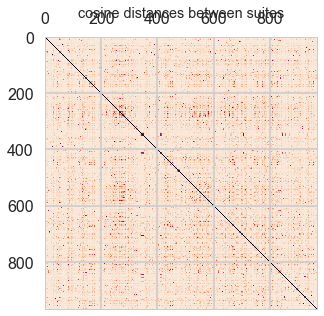

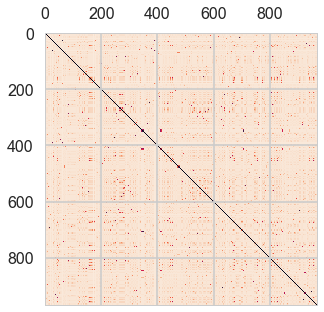

In [44]:
# perform hierarchical clustering
distances, linkage_matrix, c, _ = do_hierarch_clustering(tfidfm)


In [57]:
distances.shape

(468028,)

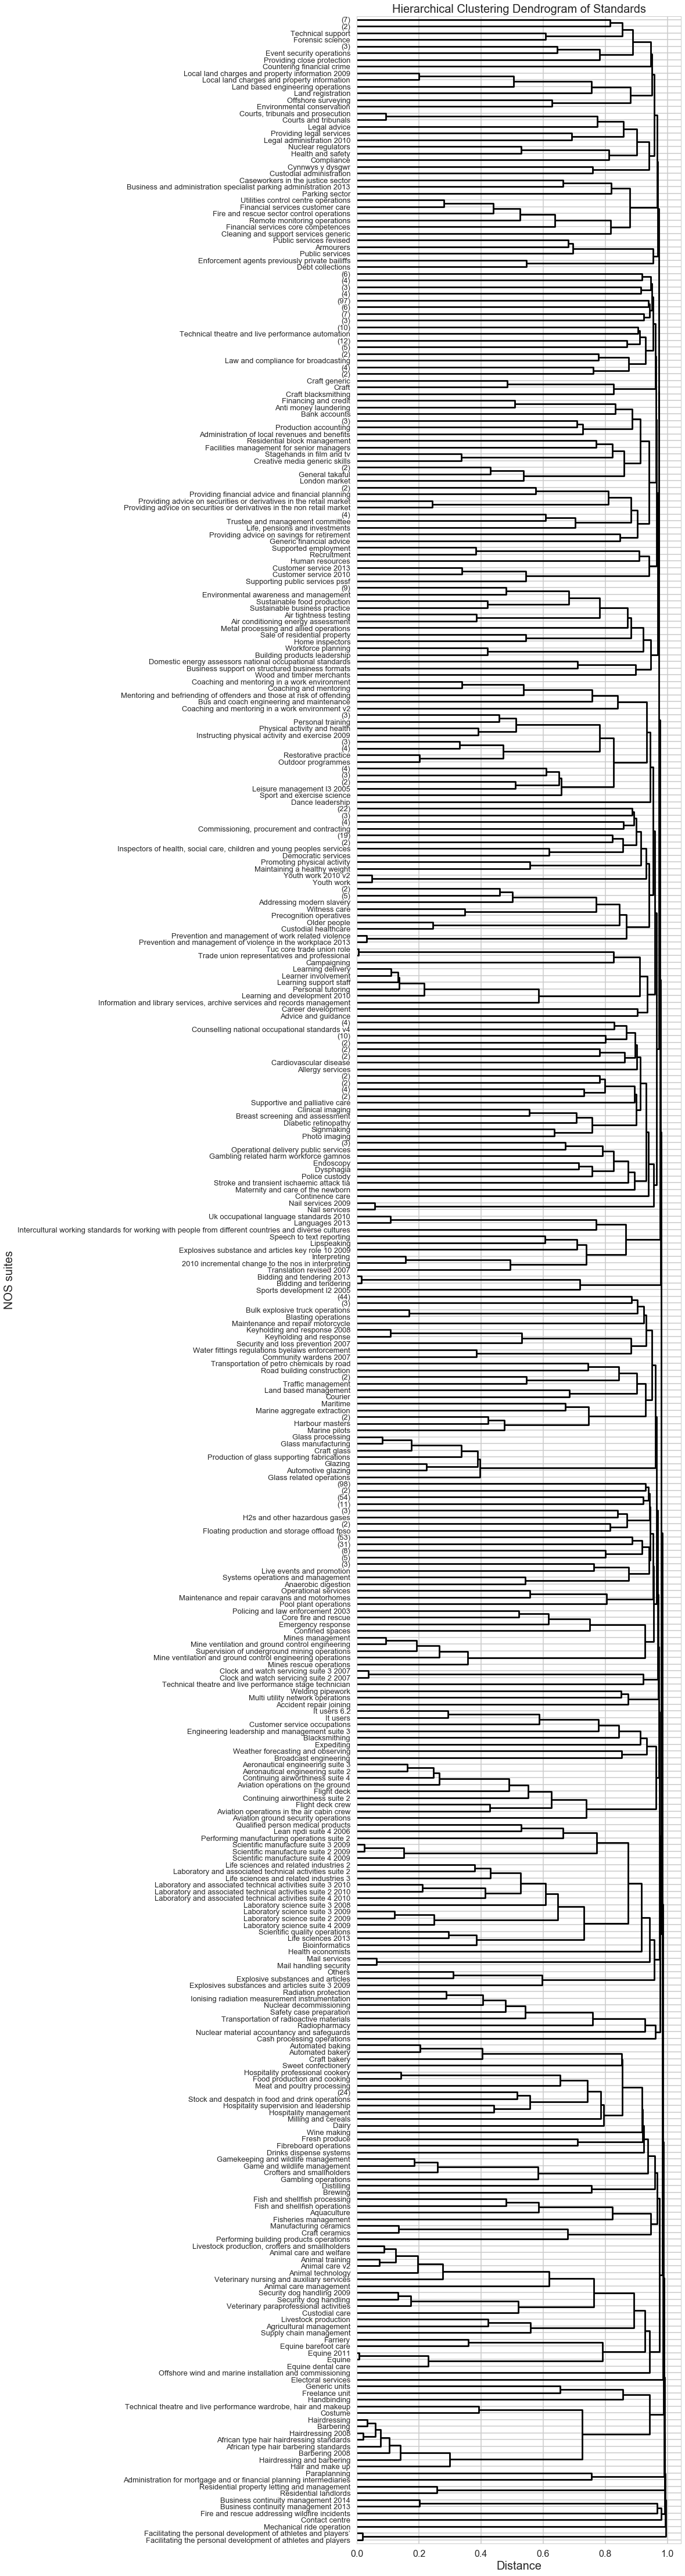

In [45]:
#Plot the dendrogram
fig, ax = plt.subplots(figsize=(10, 80)) # set size
ax = dendrogram(linkage_matrix, 
                labels = [t.capitalize() for t in standard_labels], 
                orientation = 'right', 
                leaf_font_size=6,
               color_threshold = 0,
               truncate_mode = 'level', p =20,
               above_threshold_color = 'k');

plt.tick_params(axis= 'y',
                labelsize = 13)
plt.title('Hierarchical Clustering Dendrogram of Standards', fontsize = 20)
plt.xlabel('Distance', fontsize = 20)
plt.ylabel('NOS suites',fontsize = 20)
if SAVEHC and False:
    plt.savefig(os.path.join(output_dir, 'nos_aggregated_dendrogram_{}_{}_{}.png'.format(qualifier,params['bywhich'],
                                                    params['mode'])), bbox_inches = "tight")   
    

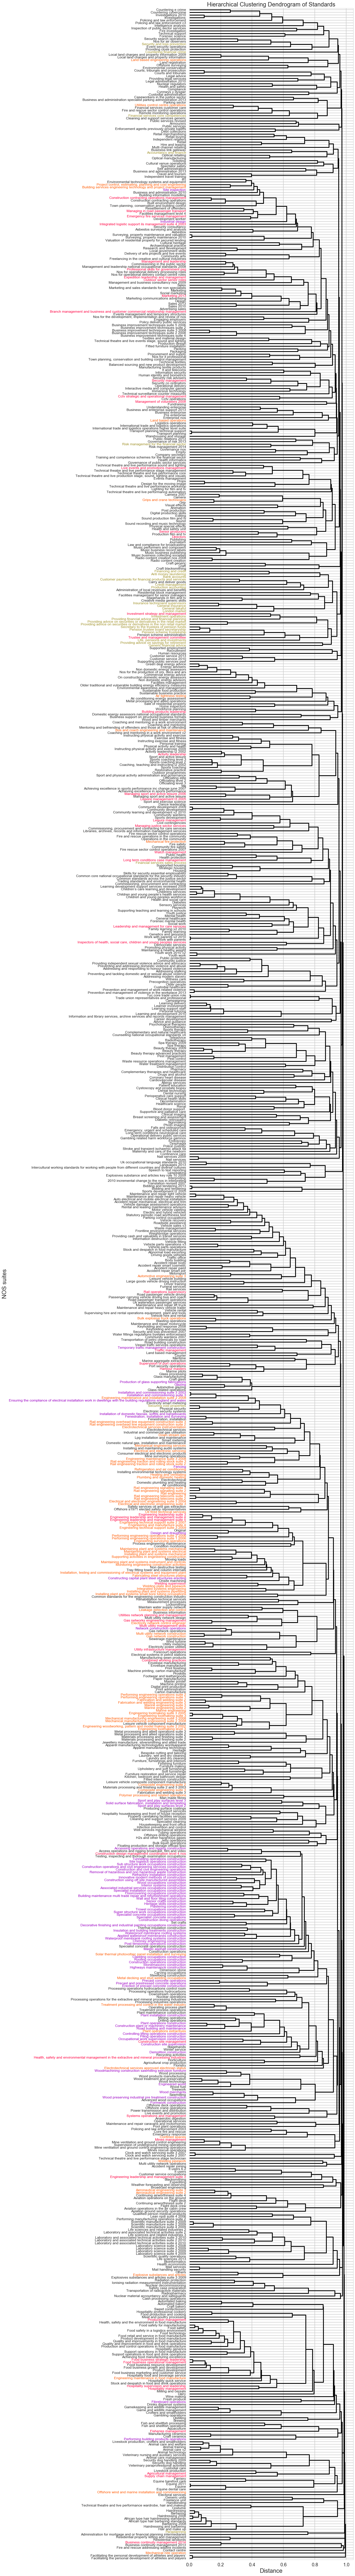

In [46]:
#Re-plot the dendrogram
fig, ax = plt.subplots(figsize=(10, 160)) # set size
ax = dendrogram(linkage_matrix, 
                labels = [t.capitalize() for t in standard_labels], 
                orientation = 'right', 
                leaf_font_size=6,
               color_threshold = 0,
               truncate_mode = 'level', p =43,
               above_threshold_color = 'k');

plt.tick_params(axis= 'y',
                labelsize = 12)
plt.title('Hierarchical Clustering Dendrogram of Standards', fontsize = 20)
plt.xlabel('Distance', fontsize = 20)
plt.ylabel('NOS suites',fontsize = 20)
T = plt.yticks()
super_suites_colours = {'Management': nesta_colours[1], 'Engineering': nesta_colours[3],
                        'FinancialServices':nesta_colours[6], 'Construction': nesta_colours[4]}
for t in T[1]:
    for which_super_suite in super_suites_names:
        if t.get_text().lower() in all_match_names[which_super_suite]:
            #print(t,',',which_super_suite)
            #plt.text(t,'r')
            t.set_color(super_suites_colours[which_super_suite])
            break

if SAVEHC:
    plt.savefig(os.path.join(output_dir, 'nos_aggregated_dendrogram_{}_{}_{}.pdf'.format(qualifier,params['bywhich'],
                                                    params['mode'])), bbox_inches = "tight")   
    

In [47]:
# extract the super-suites subset from the cosine matrix and print average similarity matrix
average_super_similarity = {}
tfidf_super = {}
for which_super_suite in super_suites_names:
    tfidf_super[which_super_suite] = tfidfm[all_matches[which_super_suite],:]

for which_super_suite in super_suites_names:
    print(which_super_suite)
    average_super_similarity[which_super_suite] = {}
    for which_super_suite2 in super_suites_names:
        print(which_super_suite2)
        A = distance.cdist(tfidf_super[which_super_suite].todense(),
                           tfidf_super[which_super_suite2].todense(), metric = 'cosine')
        N = A.shape
        print(N)
        #plt.imshow(A)
        if which_super_suite == which_super_suite2:
            B = A[np.triu_indices(N[0],1)]
        else:
            B = A#[np.triu_indices(N[0],m=N[1])]
        average_super_similarity[which_super_suite][which_super_suite2] = (np.around(np.mean(B),2),
                                                                           np.around(np.median(B),2),
                                                                           np.around(np.std(B),2))
print('Done')


Engineering
Engineering
(83, 83)
Management
(83, 59)
FinancialServices
(83, 29)
Construction
(83, 75)
Management
Engineering
(59, 83)
Management
(59, 59)
FinancialServices
(59, 29)
Construction
(59, 75)
FinancialServices
Engineering
(29, 83)
Management
(29, 59)
FinancialServices
(29, 29)
Construction
(29, 75)
Construction
Engineering
(75, 83)
Management
(75, 59)
FinancialServices
(75, 29)
Construction
(75, 75)
Done


(2775,)


(array([1.000e+00, 3.000e+00, 5.000e+00, 3.000e+01, 1.110e+02, 2.560e+02,
        3.490e+02, 3.860e+02, 3.780e+02, 1.256e+03]),
 array([0.00878073, 0.10790265, 0.20702458, 0.30614651, 0.40526844,
        0.50439036, 0.60351229, 0.70263422, 0.80175615, 0.90087807,
        1.        ]),
 <a list of 10 Patch objects>)

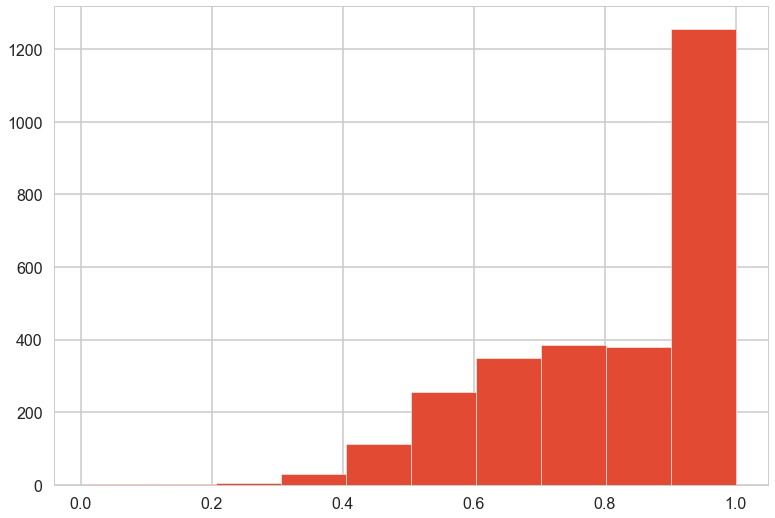

In [48]:
print(B.shape)
plt.hist(B)

In [49]:
print(average_super_similarity)
pd.DataFrame.from_dict(average_super_similarity)

{'Engineering': {'Engineering': (0.88, 0.92, 0.13), 'Management': (0.96, 0.98, 0.08), 'FinancialServices': (0.98, 0.99, 0.03), 'Construction': (0.93, 0.95, 0.07)}, 'Management': {'Engineering': (0.96, 0.98, 0.08), 'Management': (0.93, 0.96, 0.11), 'FinancialServices': (0.97, 0.98, 0.04), 'Construction': (0.96, 0.98, 0.06)}, 'FinancialServices': {'Engineering': (0.98, 0.99, 0.03), 'Management': (0.97, 0.98, 0.04), 'FinancialServices': (0.91, 0.96, 0.14), 'Construction': (0.99, 0.99, 0.03)}, 'Construction': {'Engineering': (0.93, 0.95, 0.07), 'Management': (0.96, 0.98, 0.06), 'FinancialServices': (0.99, 0.99, 0.03), 'Construction': (0.81, 0.88, 0.17)}}


Engineering          Management   FinancialServices  \
Construction       (0.93, 0.95, 0.07)  (0.96, 0.98, 0.06)  (0.99, 0.99, 0.03)   
Engineering        (0.88, 0.92, 0.13)  (0.96, 0.98, 0.08)  (0.98, 0.99, 0.03)   
FinancialServices  (0.98, 0.99, 0.03)  (0.97, 0.98, 0.04)  (0.91, 0.96, 0.14)   
Management         (0.96, 0.98, 0.08)  (0.93, 0.96, 0.11)  (0.97, 0.98, 0.04)   

                         Construction  
Construction       (0.81, 0.88, 0.17)  
Engineering        (0.93, 0.95, 0.07)  
FinancialServices  (0.99, 0.99, 0.03)  
Management         (0.96, 0.98, 0.06)

If we wanted to cut the dendrogram at a certain distance threshold, we would use fcluster as shown below

In [50]:

labels_h = fcluster(linkage_matrix, 0.8, criterion='distance')

if params['bywhich']== 'suites':
    short_df = pd.DataFrame(standard_labels)
    short_df.columns = ['Suite_names']
else:
    short_df = df_nos[['Title', 'One_suite']].iloc

short_df['hierarchical'] = labels_h

n_clusters = len(collections.Counter(labels_h))
print(n_clusters)


229


In [51]:
# print the result of the cut dendrogram
hierarchical_dict= {}
for ic in range(1,n_clusters+1):
    hierarchical_dict['{}'.format(ic)] = short_df['Suite_names'][short_df['hierarchical']==ic].values
if SAVEHC:
    pd.DataFrame.from_dict(hierarchical_dict, orient = 'index').to_csv(output_dir +
                            '/Hierarchical_results_{}_{}_{}.csv'.format(qualifier,params['bywhich'],params['mode']))
    

In [ ]:
# Perform hierarchical clustering only on the suites in one super-suite (e.g. Management)
which_super_suite = 'Management'
match_name = all_match_names[which_super_suite]
match = all_matches[which_super_suite]


In [ ]:
# perform hierarchical clustering on the suites belonging to the super suite alone
distances_super, linkage_matrix_super, c_super, c_dist_super = do_hierarch_clustering(tfidfm[match,:], 
                                                                                      DOPLOTS = False)

#Plot the dendrogram again for this super-suite
standard_labels_super = [standard_labels[t].capitalize() for t in match]

fig, ax = plt.subplots(figsize=(10, 20)) # set size
ax = dendrogram(linkage_matrix_super, 
                labels = standard_labels_super, 
                orientation = 'right', 
                leaf_font_size=6,
               color_threshold = 0,
               truncate_mode = 'level', p =40,
               above_threshold_color = 'k');

plt.tick_params(axis= 'y',
                labelsize = 14)
plt.title('Hierarchical Clustering Dendrogram of NOS (in super-suite {})'.format(which_super_suite), fontsize = 18)
plt.xlabel('Distance', fontsize = 18)
plt.ylabel('NOS suites',fontsize = 18)
if SAVEHC:
    plt.savefig(os.path.join(output_dir, 'nos_dendrogram_{}_{}_{}_{}.png'.format(which_super_suite,
                                            qualifier,params['bywhich'],params['mode'])), bbox_inches = "tight")     
    

In [ ]:
labels_h = fcluster(linkage_matrix_super, 0.9, criterion='distance')

if params['bywhich']== 'suites':
    short_df = pd.DataFrame(standard_labels_super)
    short_df.columns = ['Suite_names']
else:
    short_df = df_nos[['Title', 'One_suite']].iloc

short_df['hierarchical'] = labels_h

n_clusters = len(collections.Counter(labels_h))
print(n_clusters,len(labels_h))


# Collect and save data for graph visualisation

In [ ]:
def get_one_soc(x):
    if isinstance(x,list):
        try:
            return x[0]
        except:
            return np.nan
    else:
        return x
    
def get_one_occupation(x):
    if isinstance(x,list):
        y= ''.join(x)
    else:
        y= x
    if isinstance(y,str):
        return y.split(';')
    else:
        return y
    

In [ ]:
# collect metadata for all suites in the super-suite
metadata = {}
nb_of_nos = []
datadriven_keywords = []
expert_keywords = []
top_developed = []
top_originating = []
top_approved_year = []
top_SOC = []
top_occupation = []
# group by suite
groups = df_nos.groupby('One_suite')
# cycle through suites
for suite in match_name:
    group = groups.get_group(suite)
    # how many nos in this suite
    nb_of_nos.append(len(group))
    # suite keywords (identified before)
    datadriven_keywords.append(top_terms_dict[name + ' (top features)'])
    # list of actual keywords (ordered by popularity)
    expert_keywords.append(top_terms_dict[name + ' (keywords)'])
    # most common developing and originating organisation
    top_originating.append(group['Originating_organisation'].value_counts().index[0])
    top_developed.append(group['Developed By'].value_counts().index[0])
    # most common year approved
    top_approved_year.append(group['Date_approved_year'].value_counts().index[0])
    # top SOC code (in order)
    try:
        top_SOC.append(group['Clean SOC Code'].map(get_one_soc).value_counts().index[0])
    except:
        top_SOC.append(np.nan)
    # most common occupations
    tmp = []
    for t in group['Occupations'].map(get_one_occupation):
        tmp += t
    top_occupation.append(pd.DataFrame(tmp)[0].value_counts().index[0].strip())
    if not top_occupation[-1]:
        top_occupation[-1] = np.nan

# now make dictionary
metadata['nb_of_nos'] = nb_of_nos
metadata['datadriven_keywords'] = datadriven_keywords
metadata['expert_keywords'] = expert_keywords
metadata['top_originating_organisation'] = top_originating
metadata['top_developed_by'] = top_developed
metadata['top_approved_year'] = top_approved_year
metadata['top_soc'] = top_SOC
metadata['top_occupation'] = top_occupation
#metadata['suite_name'] = match_name
# change to dataframe
df_metadata = pd.DataFrame.from_dict(metadata)
#df_metadata = df_metadata.set_index('suite_name')


In [ ]:
df_management_cluster = df_metadata.join(short_df).set_index('Suite_names')#.drop('Suite_names')
print(df_management_cluster.head(n=3))
df_management_cluster.isnull().sum()


In [ ]:
SAVEDATAHC = False
if SAVEDATAHC:
    with open(os.path.join(output_dir, 'for_graph_visualisation/data_from_management_clustering.pickle'), 'wb') as f:
        pickle.dump((df_management_cluster, distances_super, linkage_matrix_super, c_super, c_dist_super), f)
        

### For each suite in the management super-suite, collect the same information as for the whole management supersuite and save it

In [ ]:
params2 = {}
params2['ngrams'] = 'uni'
params2['pofs'] = 'n'
params2['tfidf_min'] = 3
params2['tfidf_max'] = 0.4

params2['bywhich'] = 'docs' #'docs' #'suites'
params2['mode'] = 'tfidf' #'tfidf' #'meantfidf' #'combinedtfidf' #'meantfidf'

# get the transform tfidf
tfidf2 = define_tfidf(params2, stopwords0)

# get the matrix again (even though if the parameters stay the same, this one is the same still)
# get the features
tfidfm2, feature_names2 = get_tfidf_matrix(params2, df_nos, tfidf2)

# get labels
if params['bywhich'] == 'suites':
    standard_labels2 = list(df_nos.groupby('One_suite').groups.keys())
else:
    standard_labels2 = list(df_nos['Title'].values)

In [ ]:
tfidfm2.shape

In [ ]:
groups = df_nos.groupby('One_suite')
metadata_cols = ['NOS Title', 'URN',
       'Originating_organisation','Date_approved_year',
       'Clean Ind Review Year', 'Version_number', 'Developed By', 'Validity',
       'Keywords', 'Clean SOC Code', 'NOS Document Status', 'NOSCategory', 'Occupations',
       'One_suite']
fields_to_check = ['Overview',
       'Knowledge_and_understanding', 'Performance_criteria', 'Scope_range',
       'Glossary', 'Behaviours', 'Skills', 'Values', 'External_Links' ,
       'Links_to_other_NOS']
SAVEDATAHC = False
COLLECTDATAHC = False
t0 = time.time()
if COLLECTDATAHC:
    for suite in df_management_cluster.index[::-1]:
        print(suite)
        idx = (df_nos['One_suite'] == suite).values
        if idx.sum()>19:
            tfidfm_red = tfidfm2[idx]
            group = groups.get_group(suite)
            df_metadata_nos = group[metadata_cols]
            df_metadata_nos['fields present'] = 1
            for nos in group.index:
                fields_present = []
                for field in fields_to_check:
                    if not group[field].loc[nos] == np.nan:
                        fields_present.append(field)
                df_metadata_nos['fields present'].loc[nos] = fields_present
            # now get the rest, that is the cosine distances
            distances_suite, linkage_matrix_suite, c_suite, c_dist_suite = do_hierarch_clustering(tfidfm_red, 
                                                                                          DOPLOTS = False)
    #        if suite == 'supply chain management':
    #            distances_scm, linkage_matrix_scm, c_scm, c_dist_scm = 
    #            distances_suite, linkage_matrix_suite, c_suite, c_dist_suite
    #            break
            if SAVEDATAHC:
                with open(os.path.join(output_dir, 
                        'for_graph_visualisation/data_from_{}_suite_clustering.pickle'.format(suite)), 
                          'wb') as f:
                    pickle.dump((df_metadata_nos, distances_suite, linkage_matrix_suite, c_suite, c_dist_suite), f)
print(time.time() - t0)

In [ ]:
# do the clustering for the supply chain management suite
suite = 'supply chain management'
groups = df_nos.groupby('One_suite')
idx = (df_nos['One_suite'] == suite).values
tfidfm_red = tfidfm2[idx]
group = groups.get_group(suite)
nos_names = group['NOS Title'].values
nos_names = [t.capitalize() for t in nos_names]
# now get the rest, that is the cosine distances
distances_scm, linkage_matrix_scm, c_scm, c_dist_scm = do_hierarch_clustering(tfidfm_red, 
                                                                              DOPLOTS = False)

#Plot the dendrogram again for this suite
fig, ax = plt.subplots(figsize=(10, 50)) # set size
ax = dendrogram(linkage_matrix_scm, 
                labels = nos_names, 
                orientation = 'right', 
                leaf_font_size=6,
               color_threshold = 0,
               truncate_mode = 'level', p =40,
               above_threshold_color = 'k');

plt.tick_params(axis= 'y',
                labelsize = 14)
plt.title('Hierarchical Clustering Dendrogram of NOS (in the {} suite)'.format(suite), fontsize = 18)
plt.xlabel('Distance', fontsize = 18)
plt.ylabel('NOS titles',fontsize = 18)
if SAVEHC or True:
    plt.savefig(os.path.join(output_dir, 'nos_dendrogram_{}_{}_{}_{}_new.pdf'.format(suite.replace(' ','_'),
                                            qualifier,params['bywhich'],params['mode'])), bbox_inches = "tight")    

### Ad hoc requests

In [ ]:
print(distance.squareform(distances_scm).shape)
groups = df_nos.groupby('One_suite')

In [ ]:
group = groups.get_group('welding supervision')
print(group['tagged_tokens'].loc['eciws01.pdf'][:20])
group

In [ ]:
group = groups.get_group('engineering leadership and management suite 5')
group

In [ ]:
group = groups.get_group('engineering leadership and management suite 3')
group

## K-means

Hierarchical clustering is very informative, but does not scale well since we are calculating pairwise distances. So if we had many more standards than 400+ apprenticeship standards, we would have to explore other options.
One solution would be to pre-cluster standards into a large number of smaller clusters using a faster method, such as k-means and then do the hierarchical clustering.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

In [ ]:
SAVEKM = False

In [ ]:
params = {}
params['ngrams'] = 'uni'
params['pofs'] = 'n'
params['tfidf_min'] = 3
params['tfidf_max'] = 0.4

params['bywhich'] = 'suites' #'docs' #'suites'
params['mode'] = 'combinetfidf' #'tfidf' #'meantfidf' #'combinedtfidf' #'meantfidf'

# get the transform tfidf
tfidf = define_tfidf(params, stopwords0)

# get the matrix again (even though if the parameters stay the same, this one is the same still)
# get the features
tfidfm, feature_names = get_tfidf_matrix(params, df_nos, tfidf)

# get labels
if params['bywhich'] == 'suites':
    standard_labels = list(df_nos.groupby('One_suite').groups.keys())
else:
    standard_labels = list(df_nos['Title'].values)

In [ ]:
def get_distance_k(df_row):
    #distance = pairwise_distances(df_row.values[:4103].reshape(1, -1), 
    #                              centroids[int(df_row['k_cluster'])].reshape(1, -1)) # why until 4103?
    L = len(df_row.values) # last column is the cluster class
    distance = pairwise_distances(df_row.values[:L-1].reshape(1, -1), 
                                  centroids[int(df_row['k_cluster'])].reshape(1, -1))
    distance = distance[0][0]
    return distance

In [ ]:
# takes 5 seconds for N = 400, 20 seconds for N = 1000, 50 seconds for N = 2000, 110 seconds for 4000
N = 400
t0 = time.time()
# use approx the number of super suites SDS gave you
k = 40 
#use the number of clusters detected by the hierarchical algorithm above
#k = n_clusters 
km = KMeans(n_clusters = k, random_state = 111)
km.fit(tfidfm.toarray())
k_clusters = km.labels_.tolist()
print_elapsed(t0, task = 'kmean clustering')

In [ ]:
centroids = km.cluster_centers_

In [ ]:
short_df['k_means'] = k_clusters

In [ ]:
tfidfm_df = pd.DataFrame(tfidfm.toarray())

In [ ]:
tfidfm_df['k_cluster'] = k_clusters

In [ ]:
short_df['k_distance'] = tfidfm_df.apply(get_distance_k, axis =1)

In [ ]:
# collect the centroids (that is, the suite closest to the centroid) and print the result of the clustering
kmeans_dict= {}
most_central = []
igroup = 0
for name, group in short_df.groupby('k_means'):
    kmeans_dict['{}'.format(name)] = group['Suite_names'].values
    if igroup < 10:
        print(name, group.sort_values(by = 'k_distance').head(3))
    igroup += 1
    most_central.append(group.sort_values(by = 'k_distance').head(1))
if SAVEKM:
    pd.DataFrame.from_dict(kmeans_dict, orient = 'index').to_csv(output_dir +
                                            '/Kmeans_results_{}_{}_{}.csv'.format(qualifier,bywhich,mode))

#### HIERARCHICAL 2

We can now select representatives from each small cluster and perform hierarchical clustering again

In [ ]:
select_df = pd.concat(most_central)

In [ ]:
print(len(set(select_df['hierarchical'])))
# print the most representative suite for each cluster
select_df

In [ ]:
# find the indices of the central suites/docs
select_ix = np.array([short_df.index.get_loc(ix) for ix in select_df.index])

In [ ]:
select_standards = tfidfm.toarray()[select_ix, :]

In [ ]:
select_standards.shape

In [ ]:
#We calculate cosine distance between tf-idf vectors of the documents/suites
distances_s, linkage_matrix_s, c_s = do_hierarch_clustering(select_standards, DOPLOTS = False)
'''
distances_s = distance.pdist(select_standards, metric = 'cosine')

#We then build linkage matrix using the distances and specifying the method. For euclidean distances typically 'Ward'
#produces best results. For cosine we can only use 'average' and 'single'.
linkage_matrix_s = scipy.cluster.hierarchy.linkage(distances_s,
                                                 method = 'average',
                                                 metric = 'cosine')
#We can test how well the groupings reflect actual distances. If c > 0.75 this is considered to be sufficiently
#good representation
c, coph_dists = cophenet(linkage_matrix_s, 
                         distance.pdist(select_standards, metric = 'cosine'))
'''
1

In [ ]:
if params['bywhich'] == 'suites':
    standard_labels = list(select_df['Suite_names'].values)
else:
    standard_labels = list(select_df['Title'].values)

fig, ax = plt.subplots(figsize=(10, 15)) # set size
ax = dendrogram(linkage_matrix_s, 
                labels = standard_labels, 
                orientation = 'right', 
                leaf_font_size=6,
               color_threshold = 0.8);

plt.tick_params(axis= 'y',
                labelsize = 12)
plt.title('Hierarchical Clustering Dendrogram of Pre-clustered Standards', fontsize = 12)
plt.xlabel('Distance', fontsize = 12)
if params['bywhich'] == 'suites':
    plt.ylabel('NOS suites',fontsize = 12)
else:
    plt.ylabel('NOS titles',fontsize = 12)
if SAVEKM:
    plt.savefig(os.path.join(output_dir, 'nos_dendrogram_centroids_{}_{}_{}.svg'.format(qualifier,bywhich,mode)), 
            bbox_inches = "tight") 

Everything below is just backup, with code that is now being replaced, but the replacement has not been fully tested yet

In [ ]:
'''
The next three lines compute the tfidf matrix for the keywords extraction
'''

textfortoken= df_nos['pruned']
tfidfm = tfidf.fit_transform(textfortoken)
feature_names = tfidf.get_feature_names()

'''
The code below was used to compute the tfidf matrix to feed to the clustering algorithm. However, I want to uniform 
the way the matrix is computed for both the keywords extraction and the clustering
'''



def get_tfidfm(bywhich, mode, df_nos)
    t0 = time.time()
    if bywhich == 'suites':
        if mode == 'meantfidf':
            # this is the case where I group by suite and use the average tfidf vectore as the features to cluster
            row_names = df_nos['One_suite'].value_counts().index.values
            tfidfm = scipy.sparse.lil_matrix(np.zeros((len(row_names),len(feature_names)), dtype = np.float32))
            igroup = 0
            for name, group in df_nos.groupby('One_suite'):
                tmp = get_mean_tfidf(group['pruned'], tfidf)
                tfidfm[igroup] = tmp
                igroup += 1
        elif mode == 'combinedtfidf':
            # this is the case where I group by suite, concatenate all tokens and compute the tfidf vectors
            row_names = df_nos['One_suite'].value_counts().index.values
            tfidfm = scipy.sparse.lil_matrix(np.zeros((len(row_names),len(feature_names)), dtype = np.float32))
            igroup = 0
            for name, group in df_nos.groupby('One_suite'):
                joint_tokens = []
                for idoc in group['pruned'].index:
                    joint_tokens += group['pruned'].loc[idoc]
                tmp = tfidf.transform([joint_tokens])
                tfidfm[igroup] = tmp
                igroup += 1
        # TODO: top word embedding modes + t
    elif bywhich == 'docs':
        if mode == 'tfidf':
            # this is where I keep everything the same
            tfidfm = tfidf.fit_transform(df_nos['pruned'])
    print_elapsed(t0, 'computing the feature vector')
    tfidfm